### Figure 3 generation notebook for MERFISH single cell quality control

In [7]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import patches as mpatches
import numpy as np
import tifffile
import rasterio
import cv2
import geopandas as gpd
from shapely.geometry import shape, box
from shapely.affinity import translate
import string
import anndata as ad


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style
# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

plt.ion()

# Helper functions
def load_image_roi(file_name, window_coords):
    try:
        with rasterio.open(file_name) as aws_file:
            roi = aws_file.read(1, window=rasterio.windows.Window(*window_coords))
    except OSError:
        print(f"File read error on {file_name}")
        roi = np.zeros([window_coords[3],window_coords[2]])
        
    return np.squeeze(roi)

def convert_eight_bit(img):
    # Normalize contrast before reducing bit depth
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm_img = clahe.apply(img)    
    bg_subtract = norm_img - norm_img.min()
    
    if bg_subtract.max() == 0:
        return np.zeros(img.shape, dtype=np.uint8)
    else:
        range_norm = bg_subtract / bg_subtract.max()      
        return np.array(range_norm * 255, dtype=np.uint8)
    
def increase_brightness(img, multiplier=1, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = (255 - value) / multiplier
    v[v > lim] = 255
    v[v <= lim] = (v[v <= lim] * multiplier) + value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [8]:
# Experiment Info
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921']
region = 0

# Image input info
image_base_path = "../../../data/MosaicImages"
geom_base_path = "../../../data/RawData"
nuclear_stain = "DAPI"
cytoplasmic_stain = "Cellbound3"
z_level = 3

# Load the data
transformation_matrix = {}
boundaries = {}
transcripts = {}
dapi_mosaic = {}
cellbound3_mosaic = {}

for experiment in experimentName:
    # Formatted input paths using merfish_analysis folder structure, change to fit your data paths
    nuclear_file_name = f"{image_base_path}/{experiment}/mosaic_{nuclear_stain}_z{z_level}.tif"
    cyto_file_name = f"{image_base_path}/{experiment}/mosaic_{cytoplasmic_stain}_z{z_level}.tif"
    geometry_file_name = f"{geom_base_path}/{experiment}/cell_boundaries.geojson"
    transcripts_file_name = f"{geom_base_path}/{experiment}/barcodes.csv"
    transformation_matrix_file_name = f"{geom_base_path}/{experiment}/micron_to_mosaic_pixel_transform.csv"
    
    # Transformation matrix
    transformation_matrix[experiment] = np.loadtxt(transformation_matrix_file_name)

    print('Transformation matrix loaded.')

    # Segmentation boundaries
    boundaries[experiment] = gpd.read_file(geometry_file_name)

    print('Segmentation boundaries loaded.')

    # Transcripts
    transcripts[experiment] = pd.read_csv(transcripts_file_name)

    print('Transcripts loaded.')

    # DAPI mosaic
    dapi_mosaic[experiment] = tifffile.TiffFile(nuclear_file_name).asarray()

    print('DAPI mosaic loaded.')

    # Cellbound3 mosaic
    cellbound3_mosaic[experiment] = tifffile.TiffFile(cyto_file_name).asarray()

    print('Cellbound3 mosaic loaded.')
    
    print(experiment + ' loaded.')

Transformation matrix loaded.
Segmentation boundaries loaded.
Transcripts loaded.
DAPI mosaic loaded.
Cellbound3 mosaic loaded.
MsLiver_Cellbound_VZG116_V1_JH_09-18-2021 loaded.
Transformation matrix loaded.
Segmentation boundaries loaded.
Transcripts loaded.
DAPI mosaic loaded.
Cellbound3 mosaic loaded.
MsKidney_CellBoundary_VZG116_111921 loaded.


In [9]:
# Load AnnData objects
# Define the path of the analyzed data

dataPath = "../../../data/SingleCellData/raw"
suffixCounts = '_ProcessedSingleCellCounts.h5ad'

obj = {}

for experiment in experimentName:
    obj[experiment] = ad.read_h5ad(os.path.join(dataPath, experiment + suffixCounts))
    print(experiment + ' loaded.')
    
    # Calculate total barcode count if not already calculated
    if pd.isnull(obj[experiment].obs['barcodeCount']).sum() > 0:
        obj[experiment].obs['barcodeCount'] = obj[experiment].X.sum(axis=1)

print('AnnData objects loaded.')

MsLiver_Cellbound_VZG116_V1_JH_09-18-2021 loaded.
MsKidney_CellBoundary_VZG116_111921 loaded.
AnnData objects loaded.


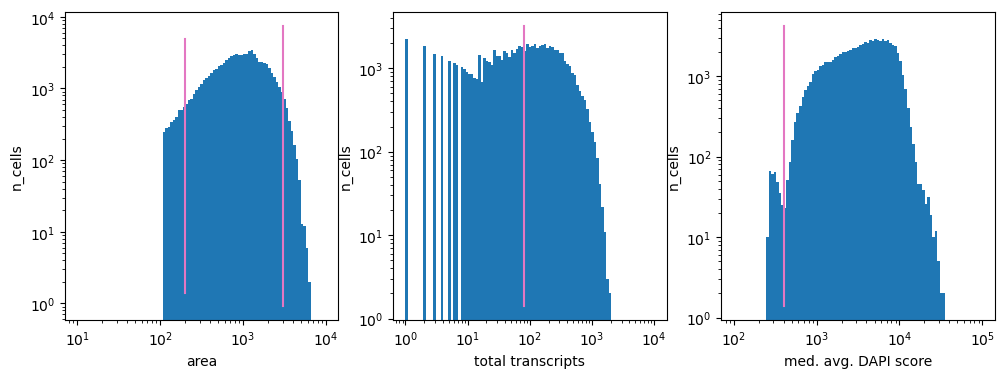

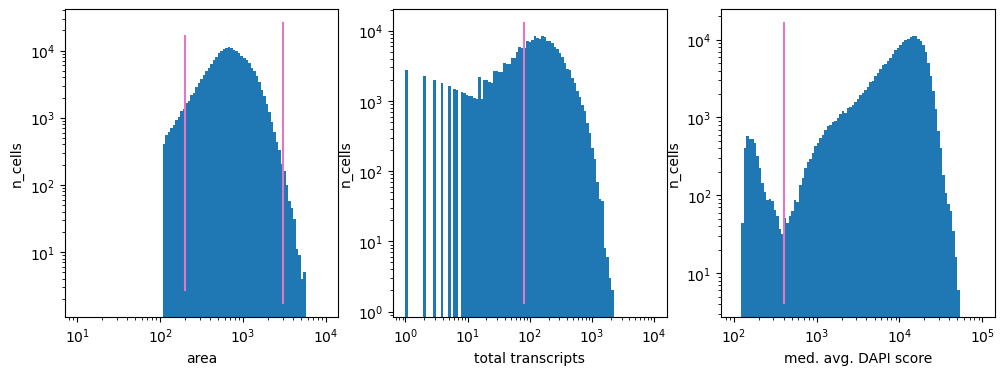

In [10]:
# Plot QC metric histograms and define cutoffs
min_area = {}
max_area = {}
min_transcripts = {}
min_DAPI = {}

for experiment in experimentName:
    min_transcripts[experiment] = 80
    min_DAPI[experiment] = 400
    min_area[experiment] = 200
    
    if experiment == experimentName[0]:
        max_area[experiment] = 3000
    if experiment == experimentName[1]:
        max_area[experiment] = 3000

for experiment in experimentName:
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    
    # Cell area
    bins = np.logspace(1,4,100)
    ax = axes[0]
    ax.hist(obj[experiment].obs['area'], bins=bins)
    ax.plot()
    ax.set_xlabel('area')
    ax.set_ylabel('n_cells')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_area[experiment], min_area[experiment]], 
            ax.get_ylim(), '-', color='tab:pink', label='cutoff')
    ax.plot([max_area[experiment], max_area[experiment]], 
            ax.get_ylim(), '-', color='tab:pink', label='cutoff')
    
    # Total transcript count
    bins = np.logspace(0,4,100)
    ax = axes[1]
    ax.hist(obj[experiment].obs['barcodeCount'], bins=bins)
    ax.set_xlabel('total transcripts')
    ax.set_ylabel('n_cells')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_transcripts[experiment], min_transcripts[experiment]], 
            ax.get_ylim(), '-', color='tab:pink', label='cutoff')
    
    # Mean DAPI score
    bins = np.logspace(2,5,100)
    ax = axes[2]
    ax.hist(obj[experiment].obs['average_DAPI_score'], bins=bins)
    ax.set_xlabel('med. avg. DAPI score')
    ax.set_ylabel('n_cells')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_DAPI[experiment], min_DAPI[experiment]], 
            ax.get_ylim(), '-', color='tab:pink', label='cutoff')

In [13]:
# Generate image viewports

# Viewport location. Formatted as: [column_offset (x), row_offset (y), width, height], units are pixels
viewport = {}
blue = {}
green = {}
red = {}
aligned_cells = {}
viewport_tx = {}

for experiment in experimentName:
    # Liver viewport
    if experiment == experimentName[0]:
        xMin = 20000
        yMin = 20000
        width = 1000
        height = 1000
        xMax = xMin + width
        yMax = yMin + height
        viewport[experiment] = [xMin, yMin, width, height] 
        
    # Kidney viewport
    if experiment == experimentName[1]:
        xMin = 20000
        yMin = 20000
        width = 1000
        height = 1000
        xMax = xMin + width
        yMax = yMin + height
        viewport[experiment] = [xMin, yMin, width, height] 
        
    # Filepaths
    nuclear_file_name = f"{image_base_path}/{experiment}/mosaic_{nuclear_stain}_z{z_level}.tif"
    cyto_file_name = f"{image_base_path}/{experiment}/mosaic_{cytoplasmic_stain}_z{z_level}.tif"


    # Read image data from viewport
    green_scale = 0.5
    blue[experiment] = convert_eight_bit(load_image_roi(nuclear_file_name, viewport[experiment]).astype('uint16'))
    green[experiment] = convert_eight_bit((load_image_roi(cyto_file_name, viewport[experiment]) * green_scale).astype('uint16'))

    # Filter geometry data to match viewport
    viewport_poly = box(viewport[experiment][0],
                        viewport[experiment][1], 
                        viewport[experiment][0] + viewport[experiment][2],
                        viewport[experiment][1] + viewport[experiment][3])
    viewport_cells = boundaries[experiment][boundaries[experiment].intersects(viewport_poly)]
    aligned_cells[experiment] = viewport_cells.translate(xoff=0-viewport[experiment][0], 
                                                         yoff=0-viewport[experiment][1])

    # Filter transcripts
    viewport_tx[experiment] = transcripts[experiment][(transcripts[experiment]['global_x_mosaic'] > xMin) &
                             (transcripts[experiment]['global_x_mosaic'] < xMax) &
                             (transcripts[experiment]['global_y_mosaic'] > yMin) &
                             (transcripts[experiment]['global_y_mosaic'] < yMax)]
print('Viewports created.')

/data01/jonathan.liu/miniconda3/envs/geo_env/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/data01/jonathan.liu/miniconda3/envs/geo_env/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Viewports created.


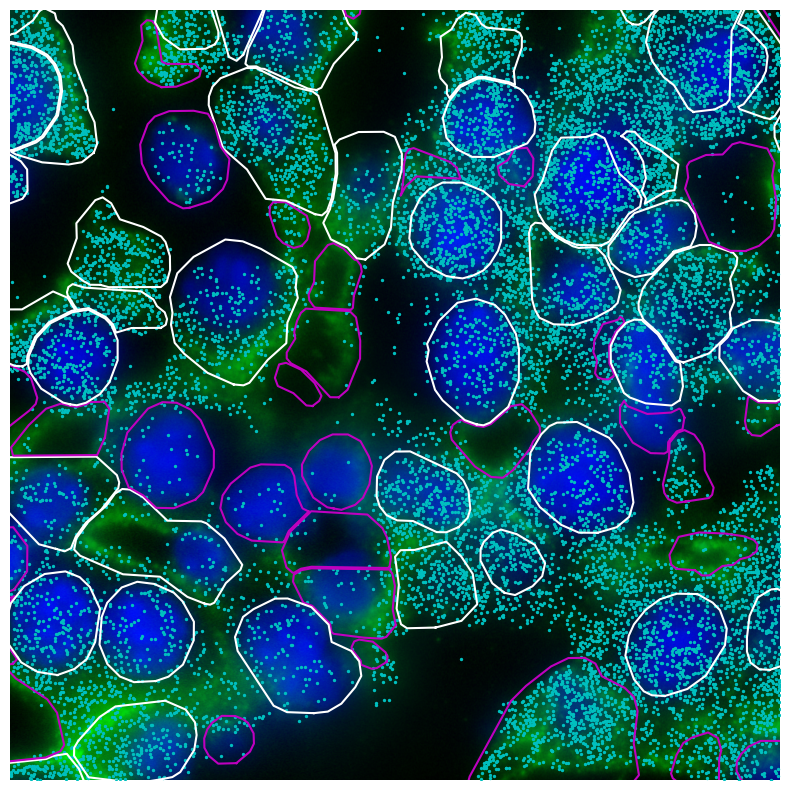

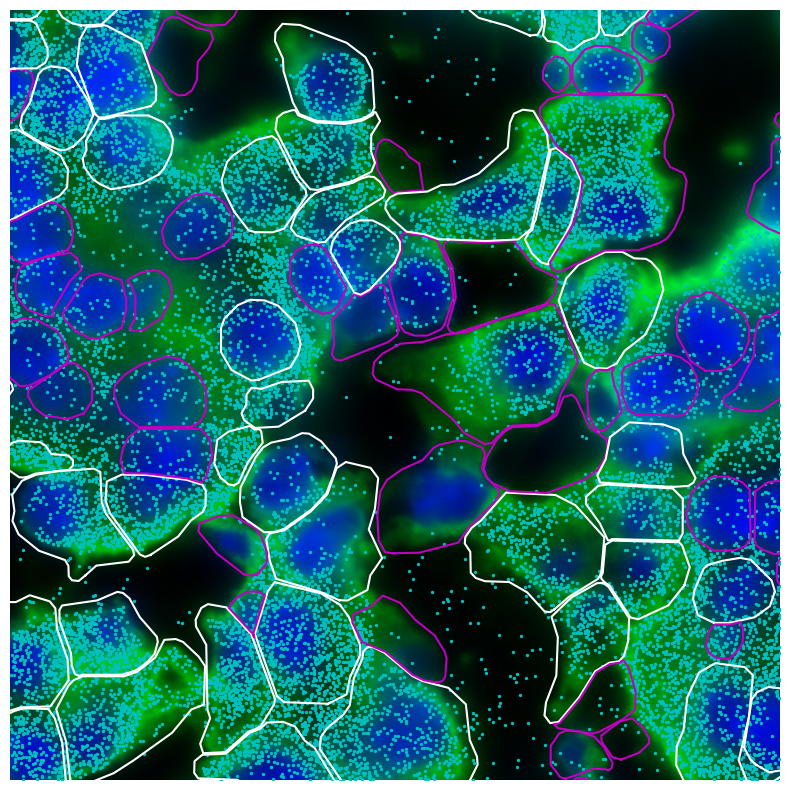

In [14]:
# Plot viewports

for experiment in experimentName:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('off')
    
    # Raw images
    red = np.zeros(blue[experiment].shape, dtype=np.uint8)
    im = cv2.merge((red, green[experiment], blue[experiment]))
    ax.imshow(im, origin='lower')
    
    # Positions of decoded transcripts + segmented boundaries
    for ID in aligned_cells[experiment].index:
        cell = aligned_cells[experiment].loc[ID]
        entityID = str(ID)
        if (obj[experiment].obs.loc[entityID]['average_DAPI_score'] > min_DAPI[experiment]) & \
            (obj[experiment].obs.loc[entityID]['area'] > min_area[experiment]) & \
            (obj[experiment].obs.loc[entityID]['area'] < max_area[experiment]) & \
            (obj[experiment].obs.loc[entityID]['barcodeCount'] > min_transcripts[experiment]):
            ax.plot(*cell.exterior.xy, "w")
        else:
            ax.plot(*cell.exterior.xy, "m")
    ax.scatter(viewport_tx[experiment]['global_x_mosaic'] - viewport[experiment][0],
                    viewport_tx[experiment]['global_y_mosaic'] - viewport[experiment][1],
                    c='c',
                    s=2)
    ax.set_xlim(0, viewport[experiment][2])
    ax.set_ylim(0, viewport[experiment][3])

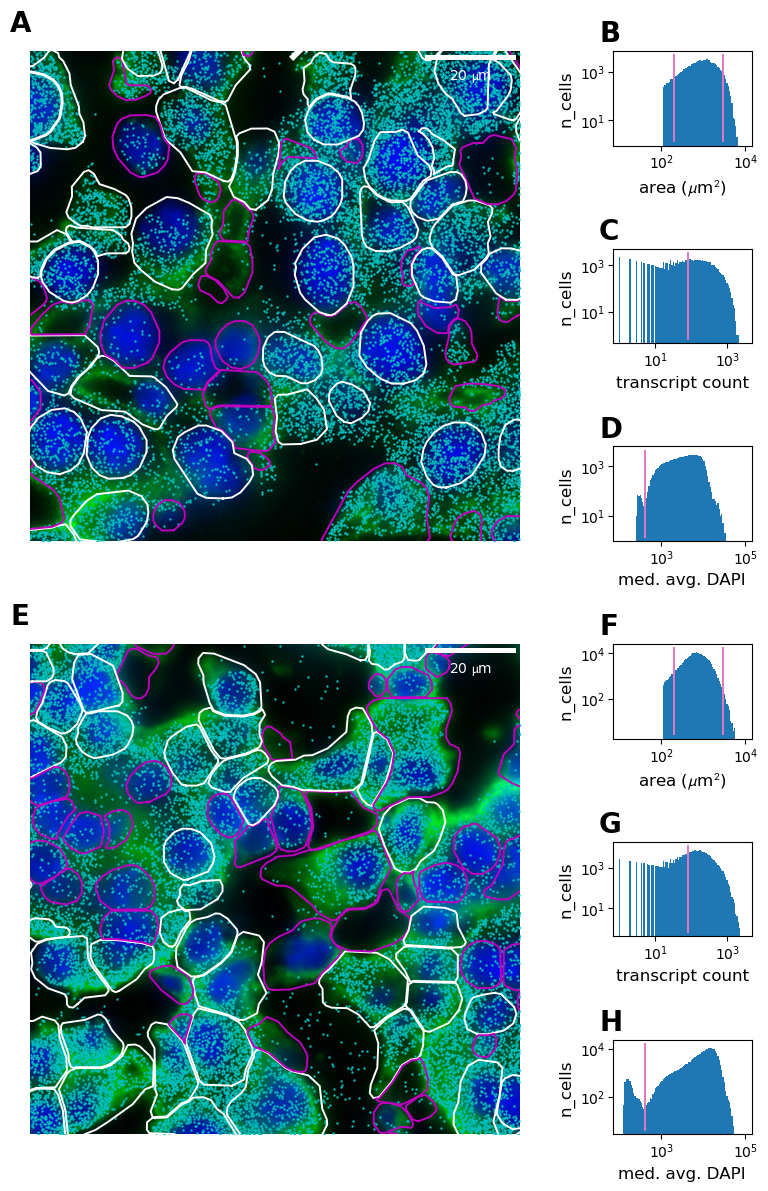

In [15]:
# Plot the whole figure
set_plotting_style()

fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(8,12)) #Create a grid
gs = axes[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for the image panels
for i in [0,1,2,3,4,5]:
    for j in [0,1,2]:
        axes[i,j].remove()

axbig1 = fig.add_subplot(gs[0:3, 0:3])
axbig2 = fig.add_subplot(gs[3:6, 0:3])

# Panel A: liver image overlay
experiment = experimentName[0]
size_of_one_pixel = 1 / transformation_matrix[experiment][0,0]
ax = axbig1

# Raw images
red = np.zeros(blue[experiment].shape, dtype=np.uint8)
im = cv2.merge((red, green[experiment], blue[experiment]))
ax.imshow(im, origin='lower')
ax.axis('off')

# Positions of decoded transcripts + segmented boundaries
for ID in aligned_cells[experiment].index:
        cell = aligned_cells[experiment].loc[ID]
        entityID = str(ID)
        if (obj[experiment].obs.loc[entityID]['average_DAPI_score'] > min_DAPI[experiment]) & \
            (obj[experiment].obs.loc[entityID]['area'] > min_area[experiment]) & \
            (obj[experiment].obs.loc[entityID]['area'] < max_area[experiment]) & \
            (obj[experiment].obs.loc[entityID]['barcodeCount'] > min_transcripts[experiment]):
            ax.plot(*cell.exterior.xy, "w")
        else:
            ax.plot(*cell.exterior.xy, "m")
ax.scatter(viewport_tx[experiment]['global_x_mosaic'] - viewport[experiment][0],
                viewport_tx[experiment]['global_y_mosaic'] - viewport[experiment][1],
                c='c',
                s=2)
ax.set_xlim(0, viewport[experiment][2])
ax.set_ylim(0, viewport[experiment][3])
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
ax.add_artist(scalebar)

# arrow to annotate example of bad segmentation
arrow = mpatches.FancyArrowPatch((530,980), (580,1030), color='w', mutation_scale=20)
ax.add_patch(arrow)

# Panel B: histogram of cell areas
ax = axes[0,3]
bins = np.logspace(1,4,100)
ax.hist(obj[experiment].obs.area,bins=bins, label='data')
ax.set_xlabel('area ($\mu$m$^2$)')
ax.set_ylabel('n_cells')
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
ax.plot([min_area[experiment], min_area[experiment]], ylim, '-', color='tab:pink', label='cutoff')
ax.plot([max_area[experiment], max_area[experiment]], ylim, '-', color='tab:pink')
#ax[0,3].legend()

# Panel C: Vizgen histogram of cell counts
ax = axes[1,3]
bins = np.logspace(0,3.5,100)
ax.hist(obj[experiment].obs.barcodeCount,bins=bins, label='data')
ax.set_xlabel('transcript count')
ax.set_ylabel('n_cells')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([min_transcripts[experiment], 
         min_transcripts[experiment]], ax.get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[1,3].legend()

# Panel D: Vizgen histogram of average DAPI intensities
ax = axes[2,3]
bins = np.logspace(2,5,100)
ax.hist(obj[experiment].obs['average_DAPI_score'],bins=bins, label='data')
ax.set_xlabel('med. avg. DAPI')
ax.set_ylabel('n_cells')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([min_DAPI[experiment], min_DAPI[experiment]], ax.get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[2,3].legend()

# Panel E: kidney image overlay
experiment = experimentName[1]
size_of_one_pixel = 1 / transformation_matrix[experiment][0,0]
ax = axbig2

# Raw images
red = np.zeros(blue[experiment].shape, dtype=np.uint8)
im = cv2.merge((red, green[experiment], blue[experiment]))
ax.imshow(im, origin='lower')
ax.axis('off')

# Positions of decoded transcripts + segmented boundaries
for ID in aligned_cells[experiment].index:
        cell = aligned_cells[experiment].loc[ID]
        entityID = str(ID)
        if (obj[experiment].obs.loc[entityID]['average_DAPI_score'] > min_DAPI[experiment]) & \
            (obj[experiment].obs.loc[entityID]['area'] > min_area[experiment]) & \
            (obj[experiment].obs.loc[entityID]['area'] < max_area[experiment]) & \
            (obj[experiment].obs.loc[entityID]['barcodeCount'] > min_transcripts[experiment]):
            ax.plot(*cell.exterior.xy, "w")
        else:
            ax.plot(*cell.exterior.xy, "m")
ax.scatter(viewport_tx[experiment]['global_x_mosaic'] - viewport[experiment][0],
                viewport_tx[experiment]['global_y_mosaic'] - viewport[experiment][1],
                c='c',
                s=2)
ax.set_xlim(0, viewport[experiment][2])
ax.set_ylim(0, viewport[experiment][3])
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
ax.add_artist(scalebar)

# arrow to annotate example of bad segmentation
arrow = mpatches.FancyArrowPatch((1000, 1400), (1050,1350), color='w', mutation_scale=20)
ax.add_patch(arrow)

# Panel F: histogram of cell areas
ax = axes[3,3]
bins = np.logspace(1,4,100)
ax.hist(obj[experiment].obs.area,bins=bins, label='data')
ax.set_xlabel('area ($\mu$m$^2$)')
ax.set_ylabel('n_cells')
ax.set_xscale('log')
ax.set_yscale('log')
ylim = ax.get_ylim()
ax.plot([min_area[experiment], min_area[experiment]],ylim, '-', color='tab:pink', label='cutoff')
ax.plot([max_area[experiment], max_area[experiment]],ylim, '-', color='tab:pink')
#ax[3,3].legend()

# Panel G: Vizgen histogram of cell counts
ax = axes[4,3]
bins = np.logspace(0,3.5,100)
ax.hist(obj[experiment].obs.barcodeCount,bins=bins, label='data')
ax.set_xlabel('transcript count')
ax.set_ylabel('n_cells')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([min_transcripts[experiment], 
         min_transcripts[experiment]], ax.get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[4,3].legend()

# Panel H: Vizgen histogram of average DAPI intensities
ax = axes[5,3]
bins = np.logspace(2,5,100)
ax.hist(obj[experiment].obs['average_DAPI_score'],bins=bins, label='data')
ax.set_xlabel('med. avg. DAPI')
ax.set_ylabel('n_cells')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([min_DAPI[experiment], min_DAPI[experiment]], ax.get_ylim(), '-', color='tab:pink', label='cutoff')
#ax[5,3].legend()


# Label subpanels
axes_all = [axbig1, axes[0,3], axes[1,3], axes[2,3], axbig2, axes[3,3], axes[4,3], axes[5,3]]
for n, ax in enumerate(axes_all):
    if n == 0 or n == 4:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

fig.tight_layout()
plt.show()

In [9]:
# Export figures
fig.savefig('../../figures/Fig3_singlecellQC.svg', transparent=True)
fig.savefig('../../figures/Fig3_singlecellQC.png', transparent=True)

print('Figures saved.')

Figures saved.


In [299]:
# What was the yield?
def filter_cells(obj, min_area, max_area, min_transcripts, min_DAPI):
    return obj[(obj.obs['area'] > min_area) & 
              (obj.obs['area'] < max_area) & 
              (obj.obs['barcodeCount'] > min_transcripts) & 
              (obj.obs['average_DAPI_score'] > min_DAPI)]

# Create filtered AnnData objects
obj_filter = {}

for experiment in experimentName:
    obj_filter[experiment] = filter_cells(obj[experiment],
                                         min_area[experiment],
                                         max_area[experiment],
                                         min_transcripts[experiment],
                                         min_DAPI[experiment])

print('Anndata objects filtered.')

# Calculate yield and number of cells
n_cells_raw = np.array([len(obj[x]) for x in experimentName])
n_cells_physical = np.array([len(obj[x][obj[x].obs['area'] > 
                                min_area[x]]) for x in experimentName])
n_cells_filter = np.array([len(obj_filter[x]) for x in experimentName])
filter_yield = 100 * n_cells_filter / n_cells_raw

print(n_cells_raw)
print(n_cells_physical)
print(n_cells_filter)
print(filter_yield)

# Overall yield and number of cells
print('Overall number of liver cells: ' + str(n_cells_raw[0]) + ' raw, ' + str(n_cells_filter[0]) + ' filtered.')
print('Overall number of kidney cells: ' + str(n_cells_raw[1]) + ' raw, ' + 
     str(n_cells_filter[1]) + ' filtered.')

Anndata objects filtered.
[ 83410 212090]
[ 79976 204540]
[ 34217 126547]
[41.02265915 59.66665095]
Overall number of liver cells: 83410 raw, 34217 filtered.
Overall number of kidney cells: 212090 raw, 126547 filtered.


In [300]:
# How many transcripts were retained in the single cell partitioning?
N_transcripts_detected = {}
N_transcripts_partitioned = {}
frac_partitioned = {}

for experiment in experimentName:
    N_transcripts_detected[experiment] = len(transcripts[experiment])
    N_transcripts_partitioned[experiment] = obj[experiment].X.sum()

    frac_partitioned[experiment] = N_transcripts_partitioned[experiment] / N_transcripts_detected[experiment]
    
    print(str(frac_partitioned[experiment]) + ' of detected transcripts assigned to cells for ' + experiment)


0.684126968527623 of detected transcripts assigned to cells for MsLiver_Cellbound_VZG116_V1_JH_09-18-2021
0.6843163024248601 of detected transcripts assigned to cells for MsKidney_CellBoundary_VZG116_111921


In [301]:
# Save the filtered Anndata objects
savePath = '../../../data/SingleCellData/raw'

for experiment in experimentName:
    obj_filter[experiment].write(os.path.join(savePath, experiment + '_FilteredSingleCellCounts.h5ad'))
    
print('Filtered Anndata objects saved.')

Filtered Anndata objects saved.
